<a href="https://www.kaggle.com/code/mohdmuttalib/mayo-clinic-13261313?scriptVersionId=140452355" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<p id="toc"></p>
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" role="tab" aria-controls="home"><center><br>CONTENTS</center></h2>

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#background">0&nbsp;&nbsp;&nbsp;&nbsp;BACKGROUND INFORMATION</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#imports">1&nbsp;&nbsp;&nbsp;&nbsp;IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#metadata">2&nbsp;&nbsp;&nbsp;&nbsp;METADATA ANALYSIS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 16px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: black; background-color: #ffffff;"><a href="#img">3&nbsp;&nbsp;&nbsp;&nbsp;IMAGE ANALYSIS</a></h3>

---


<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#F08080; border:0; color:black' role="tab" aria-controls="home"><center><br>If you find this notebook useful, do give me an upvote, it motivates me a lot.<br><br> This notebook is still a work in progress. Keep checking for further developments!😊</center></h3>

<a id="background"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="background"><left><br>&nbsp0. BACKGROUND INFORMATION <a href="#toc">&#10514;</a><br></left> </h2>

# Task Description:

In this competition, we'll classify the blood clot origins in acute ischemic stroke (AIS). There are **2** major AIS etiology subtypes:

* **Cardioembolic (CE)**
* **Large Artery Atherosclerosis (LAA)**

=> This is a **classification** problem

# File + Data Field Descriptions:

1. **train/**: A folder containing images in the TIFF format to be used as training data.
2. **test/**: A folder containing images to be used as test data. The actual test data comprises about 280 images.
3. **other/**: A supplemental set of images with a either an unknown etiology or an etiology other than CE or LAA.
4. **train.csv**: Contains annotations for images in the `train/` folder.
    * `image_id`: A unique identifier for this instance having the form `{patient_id}_{image_num}`. Corresponds to the image `{image_id}.tif`.
    * `center_id`: Identifies the medical center where the slide was obtained.
    * `patient_id`: Identifies the patient from whom the slide was obtained.
    * `image_num`: Enumerates images of clots obtained from the same patient.
    * `label`: The etiology of the clot, either CE or LAA. This field is the classification target.
5. **test.csv**: Annotations for images in the `test/` folder. Has the same fields as train.csv excluding label.
6. **other.csv**: Annotations for images in the `other/` folder. Has the same fields as train.csv. The `center_id` is unavailable for these images however.
    * `label`: The etiology of the clot, either `Unknown` or `Other`.
    * `other_specified`: The specific etiology, when known, in case the etiology is labeled as `Other`.
7. **sample_submission.csv**: A sample submission file in the correct format. Note in particular that you should make **one prediction** per `patient_id`, not per `image_id`.


# Evaluation Metric:

Submissions are evaluated using a weighted multi-class logarithmic loss. The overall effect is such that each class is roughly equally important for the final score.

Each image has been labeled with an etiology class, either CE or LAA. For each image, you must submit a probability for each class. The formula is then:

$$Log Loss=−\frac{\sum_{i=1}^{M}w_i.\sum_{j=1}^{N_i}\frac{y_{ij}}{N_i}.ln p_{ij}}{\sum_{i=1}^{M}w_i}$$

where 𝑁 is the number of images in the class set, 𝑀 is the number of classes,  ln is the natural logarithm, $y_{ij}$ is 1 if observation 𝑖 belongs to class 𝑗 and 0 otherwise, $p_{ij}$ is the predicted probability that image 𝑖 belongs to class 𝑗.

The submitted probabilities for a given image are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with $max(min(p,1−10^{15}),10^{15})$.

# Submission File Format:

For each `patient_id` in the test set, you must predict a probability for each of the two etiology classes. The file should contain a header and have the following format:

```
patient_id,CE,LAA
01f2b3,0.5,0.5
04de22,0.5,0.5
0a47c9,0.5,0.5
0af8b6,0.5,0.5
...

```

<a id="imports"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="imports"><left><br>&nbsp1. IMPORTS <a href="#toc">&#10514;</a><br></left> </h2>

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from glob import glob
from pprint import pprint
from collections import defaultdict
import gc

import plotly
from plotly import tools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio
import plotly.graph_objects as go
#pio.templates.default = 'plotly_white'
sns.set_theme(style="dark")
import cv2
import tifffile as tiff
from PIL import Image

import warnings
warnings.simplefilter("ignore")

# Load Datasets

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
other_df = pd.read_csv('../input/mayo-clinic-strip-ai/other.csv')

## *Train Dataset*

In [3]:
gmap = np.array([[1,2,3], [2,3,4], [1,2,3],[2,3,4],[1,2,3]])
train_df.head(5).style.background_gradient(axis=None,gmap=gmap, cmap='Purples', 
                                            subset=['image_id','patient_id','label'])

## *Test Dataset*

In [4]:
test_df.head(5).style.background_gradient(axis=None,gmap=[[1,2],[2,3],[1,2],[2,3]], 
                                          cmap='Purples', 
                                          subset=['image_id','patient_id'])

## *Other Dataset*

In [5]:
other_df.head(5).style.background_gradient(axis=None,gmap=gmap, cmap='Purples', 
                                            subset=['image_id','image_num','label'])

<a id="metadata"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="metadata"><left><br>&nbsp2. METADATA ANALYSIS <a href="#toc">&#10514;</a><br></left> </h2>

# Statistical Description

In [6]:
# https://www.kaggle.com/code/toomuchsauce/mental-health-plotly-interactive-viz
def EDA(df):
    
    print('\033[1m' +'EXPLORATORY DATA ANALYSIS :'+ '\033[0m\n')
    print('\033[1m' + 'Shape of the data (rows, columns):' + '\033[0m')
    print(df.shape, 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'All columns from the dataframe :' + '\033[0m')
    print(df.columns, 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Datatypes and Missing values:' + '\033[0m')
    print(df.info(), 
          '\n------------------------------------------------------------------------------------\n')
    
    for col in df.columns:
        print('\033[1m' + 'Unique values in {} :'.format(col) + '\033[0m',len(df[col].unique()))
    print('\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Summary statistics for the data :' + '\033[0m')
    print(df.describe(include='all'), 
          '\n------------------------------------------------------------------------------------\n')
    
        
    print('\033[1m' + 'Memory used by the data :' + '\033[0m')
    print(df.memory_usage(), 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Number of duplicate values :' + '\033[0m')
    print(df.duplicated().sum())
          
EDA(train_df)

EXPLORATORY DATA ANALYSIS :

Shape of the data (rows, columns):
(754, 5) 
------------------------------------------------------------------------------------

All columns from the dataframe :
Index(['image_id', 'center_id', 'patient_id', 'image_num', 'label'], dtype='object') 
------------------------------------------------------------------------------------

Datatypes and Missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB
None 
------------------------------------------------------------------------------------

Unique values in image_id : 754
Unique values in center_id : 11
Unique values 

# Data Visualization

## *Label Distribution*

In [7]:
labels_train = train_df.groupby('label')['label'].count()
labels_other = other_df.groupby('label')['label'].count()

In [8]:
# https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


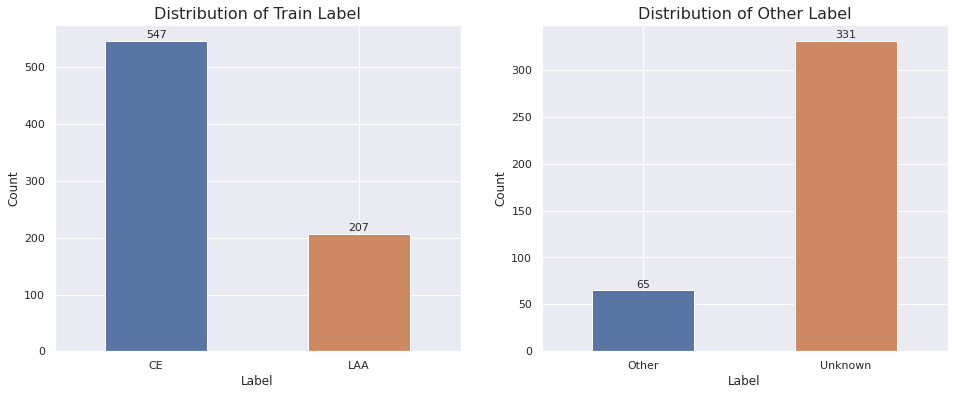

In [9]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2, figsize=(16,6))
g1 = sns.barplot(x=labels_train.index, y=labels_train.values, ax=ax[0])
ax[0].set_title("Distribution of Train Label",fontsize=16)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Label")
g1.grid(True)
change_width(ax[0],0.50)
for p in g1.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g1.text(x + w / 2, h, f'{h:.0f}\n', ha='center', va='center', size=11)
g2 = sns.barplot(x=labels_other.index, y=labels_other.values, ax=ax[1])
ax[1].set_title("Distribution of Other Label",fontsize=16)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Label")
g2.grid(True)
change_width(ax[1],0.50)
for p in g2.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g2.text(x + w / 2, h, f'{h:.0f}\n', ha='center', va='center', size=11)
plt.show()

## *Distribution of Labels by Center*

Text(0.5, 1.0, 'Distribution of Labels by Center')

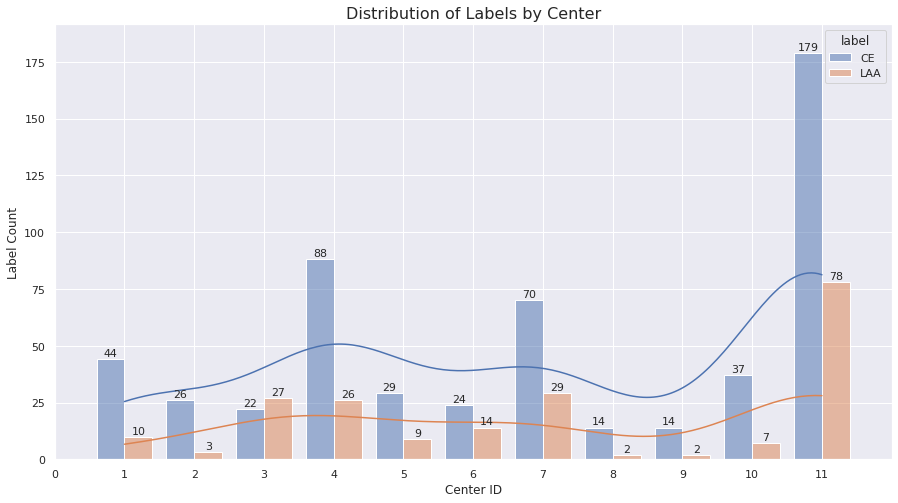

In [10]:
sns.set_style("dark")
plt.figure(figsize=(15,8))
g = sns.histplot(data=train_df, x="center_id", hue="label", 
                 multiple="dodge", color='label',discrete=True,
                 kde=True, shrink=0.8)
g.set(xlabel='Center ID', ylabel='Label Count')
g.set(xlim=(0, 12), xticks=np.arange(0,12,1))
for p in g.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g.text(x + w / 2, h, f'{h}\n', ha='center', va='center', size=11)
g.margins(y=0.07)
g.grid(True)
g.set_title('Distribution of Labels by Center', fontsize=16)

## *Distribution of Patients per Center*

In [11]:
labels = train_df.groupby('label')['label'].count()
centers = train_df.groupby("center_id")['center_id'].count()

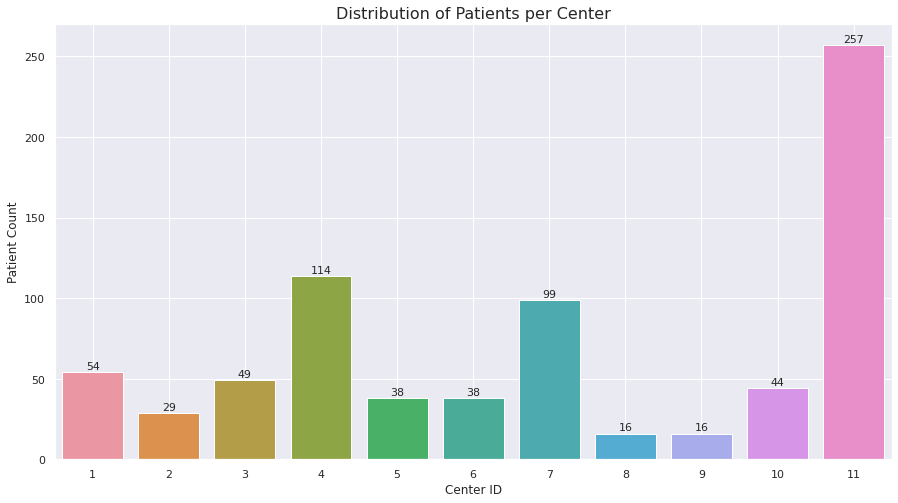

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))

g = sns.barplot(x=centers.index, y=centers.values, orient='v')
for p in g.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g.text(x + w / 2, h, f'{h:.0f}\n', ha='center', va='center', size=11)
g.set_title('Distribution of Patients per Center', fontsize=16)
g.set(ylabel="Patient Count", xlabel='Center ID')
g.grid(True)

<a id="img"></a>

<h2 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #CCCCFF; color: black;" id="img"><left><br>&nbsp3. IMAGE ANALYSIS <a href="#toc">&#10514;</a><br></left> </h2>

# Image Visualization

In [13]:
# https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration/notebook
# ../input/mayo-clinic-strip-ai/train/006388_0.tif -> id=image_path[-12:-4]
# add image path, width, height to metadata
Image.MAX_IMAGE_PIXELS = None 
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")

img_features = defaultdict(list)

for img_path in train_images:
    img = Image.open(img_path)
    img_features['image_id'].append(img_path[-12:-4])
    img_features['width'].append(img.size[0])
    img_features['height'].append(img.size[1])
    img_features['img_path'].append(img_path)
    
img_data = pd.DataFrame(img_features)
img_data.sort_values(by='image_id', inplace=True)
img_data.reset_index(inplace=True, drop=True)
img_data = img_data.merge(train_df, on='image_id')

In [14]:
img_data.head().style.background_gradient(axis=None,gmap=gmap, cmap='Purples', 
                                            subset=['image_id','img_path','label'])    

In [15]:
Image.MAX_IMAGE_PIXELS = None  # you have to set this value to allow displaying high-resolution images

# paths to CE and LAA images
CE_imgs = img_data.loc[img_data['label']=='CE','img_path']
LAA_imgs = img_data.loc[img_data['label']=='LAA','img_path']

## *Batches of Patients with CE*

Text(0.5, 0.98, 'Etiology Type: CE')

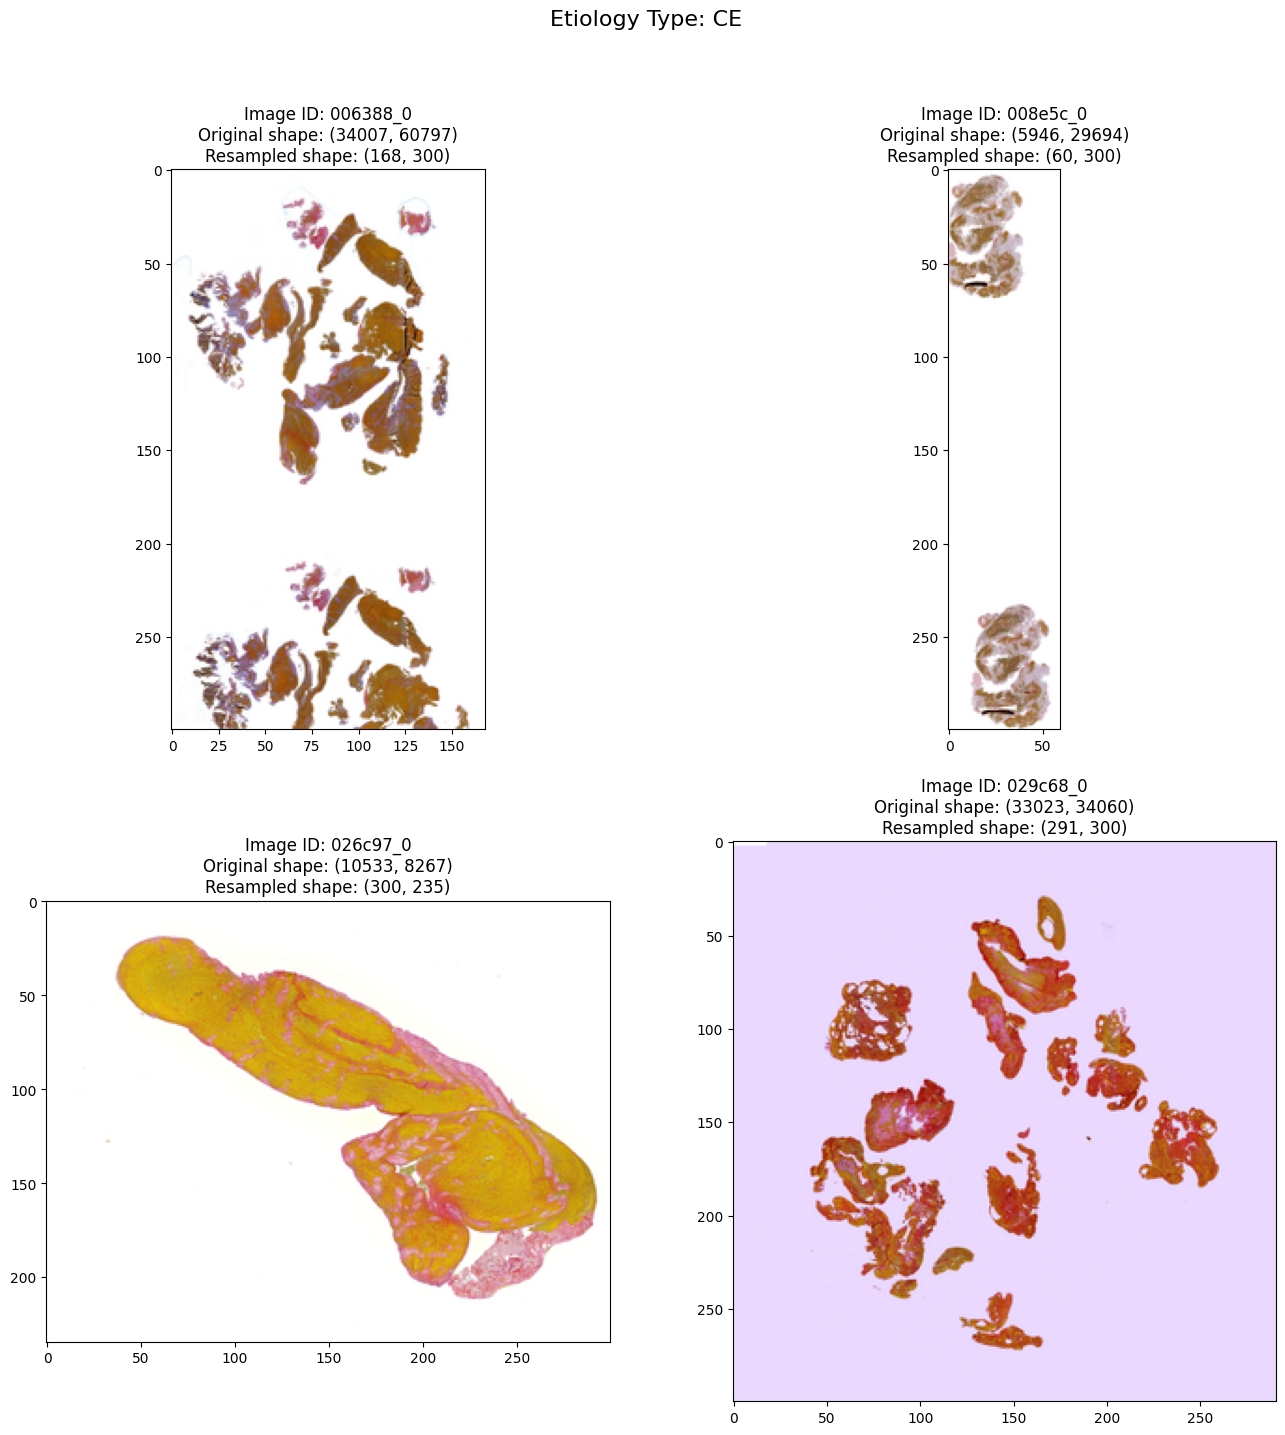

In [16]:
plt.style.use('default')
fig = plt.figure(figsize=(16,16))
for i, path in enumerate(CE_imgs[:4]):
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    original_shape = img.size
    file_name = path[-12:-4]
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    if img.height > img.width:
        img = img.transpose(Image.Resampling.LANCZOS)
    resampled_shape = img.size
    plt.imshow(img)
    plt.title(f'Image ID: {file_name}\nOriginal shape: {original_shape}\nResampled shape: {resampled_shape}')
plt.suptitle("Etiology Type: CE", fontsize=16)

## *Batches of Patients with LAA*

Text(0.5, 0.98, 'Etiology Type: LAA')

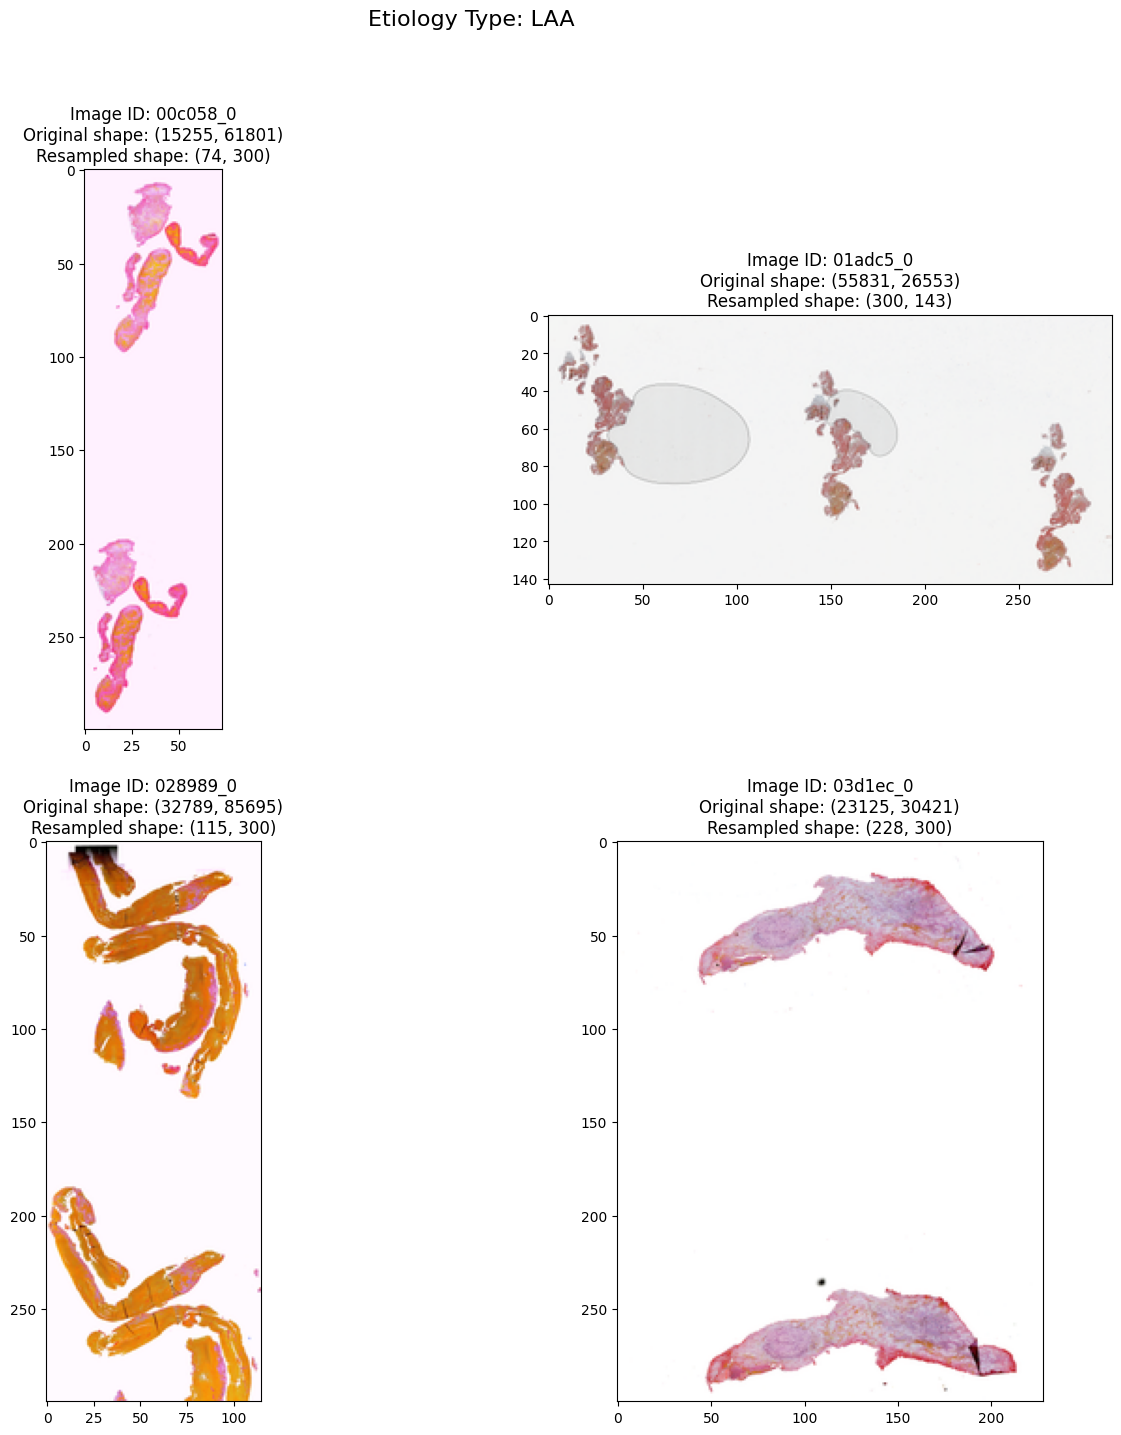

In [17]:
plt.style.use('default')
fig = plt.figure(figsize=(16,16))
for i, path in enumerate(LAA_imgs[:4]):
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    original_shape = img.size
    file_name = path[-12:-4]
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    if img.height > img.width:
        img = img.transpose(Image.Resampling.LANCZOS)
    resampled_shape = img.size
    plt.imshow(img)
    plt.title(f'Image ID: {file_name}\nOriginal shape: {original_shape}\nResampled shape: {resampled_shape}')
plt.suptitle("Etiology Type: LAA", fontsize=16)

# Case Study Analysis

## *Helper Functions*

In [18]:
def highlight(rows):
    df = lambda x: ['background: #CCCCFF' if x.name in rows
                        else '' for i in x]
    return df

In [19]:
def case_study(df, img_id):
    plt.style.use('default')
    
    path = df.loc[df['image_id'] == img_id]['img_path'].values[0]
    patient_id = df.loc[df['image_id'] == img_id]['patient_id'].values[0]
    center_id = df.loc[df['image_id'] == img_id]['center_id'].values[0]
    label = df.loc[df['image_id'] == img_id]['label'].values[0]
    
    # https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration/notebook 
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(img, (0,0), fx=0.05, fy=0.05)  
    
    print('\033[1m' + 'Case study : {}'.format(img_id) + '\033[0m')
    print('\n------------------------------\n')
    print('\033[1m' + 'General info: \n' + '\033[0m')
    print('\033[1m' + 'Patient ID: ' '\033[0m' + f'{patient_id}')  
    print('\033[1m' + 'Center ID: ' '\033[0m' + f'{center_id}')  
    print('\033[1m' + 'Etiology type: ' '\033[0m' + f'{label}')
    print('\n------------------------------\n')
    print('\033[1m' + 'Image info: \n' + '\033[0m')
    print('\033[1m' + 'Original shape: \n' + '\033[0m' + f'{img.shape}')
    print('\033[1m' + 'Resized shape: \n' + '\033[0m' + f'{image_resized.shape}')
    
    fig, ax = plt.subplots(1,2, figsize=(12,12))
    ax[0].imshow(img)
    ax[0].set_title('Original image')
    
    ax[1].imshow(image_resized)
    ax[1].set_title('Resized image')
    
    # plt.suptitle('Patient ID: ' + f'{patient_id}', y=0.7)
    plt.tight_layout()
    plt.show()
    return img, image_resized

    

In [20]:
def color_channel_analysis(resized_img):
    colors = ['Red', 'Green', 'Blue']
    plt.figure(figsize=(16,16))
    for i in range(0,9,3):
        color = int(i/3)

        # color channel
        plt.subplot(3, 3, i + 1)
        plt.imshow(resized_img[:,:,color], aspect='auto') # align all subplots
        plt.title(f'{colors[color]} Channel')

        # histogram
        ax = plt.subplot(3, 3, i + 2)
        df = resized_img[:,:,color].ravel()
        ax.axvline(150,c="red",linestyle="--")
        sns.histplot(df, bins=np.arange(0,255), ax=ax)
        plt.title(f'{colors[color]} Channel Histogram')

        # threshold
        plt.subplot(3, 3, i + 3) # threshold
        thresh = resized_img.copy()
        thresh[np.array(resized_img[:,:,color] < 150)] = 0
        plt.imshow(thresh, aspect='auto')
        plt.title(f'Threshold {colors[color]} Channel')
    
    #plt.suptitle('Color Channel Analysis', y = 1.0, fontsize=16)
    plt.tight_layout()
    plt.show()

## *Cardioembolic (CE)*

In [21]:
# Select img with width, height < 16k
img_data.loc[img_data['label']=='CE'].head(10).style.apply(highlight([4]), axis=1)

Case study : 026c97_0

------------------------------

General info: 

Patient ID: 026c97
Center ID: 4
Etiology type: CE

------------------------------

Image info: 

Original shape: 
(8267, 10533, 3)
Resized shape: 
(413, 527, 3)


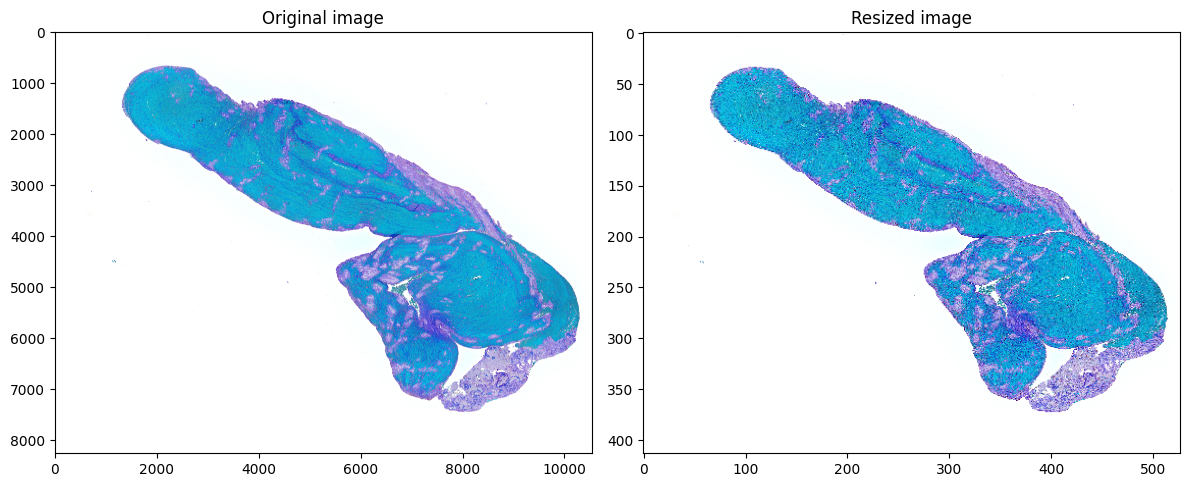

In [22]:
img_CE, img_resized_CE = case_study(img_data, '026c97_0')

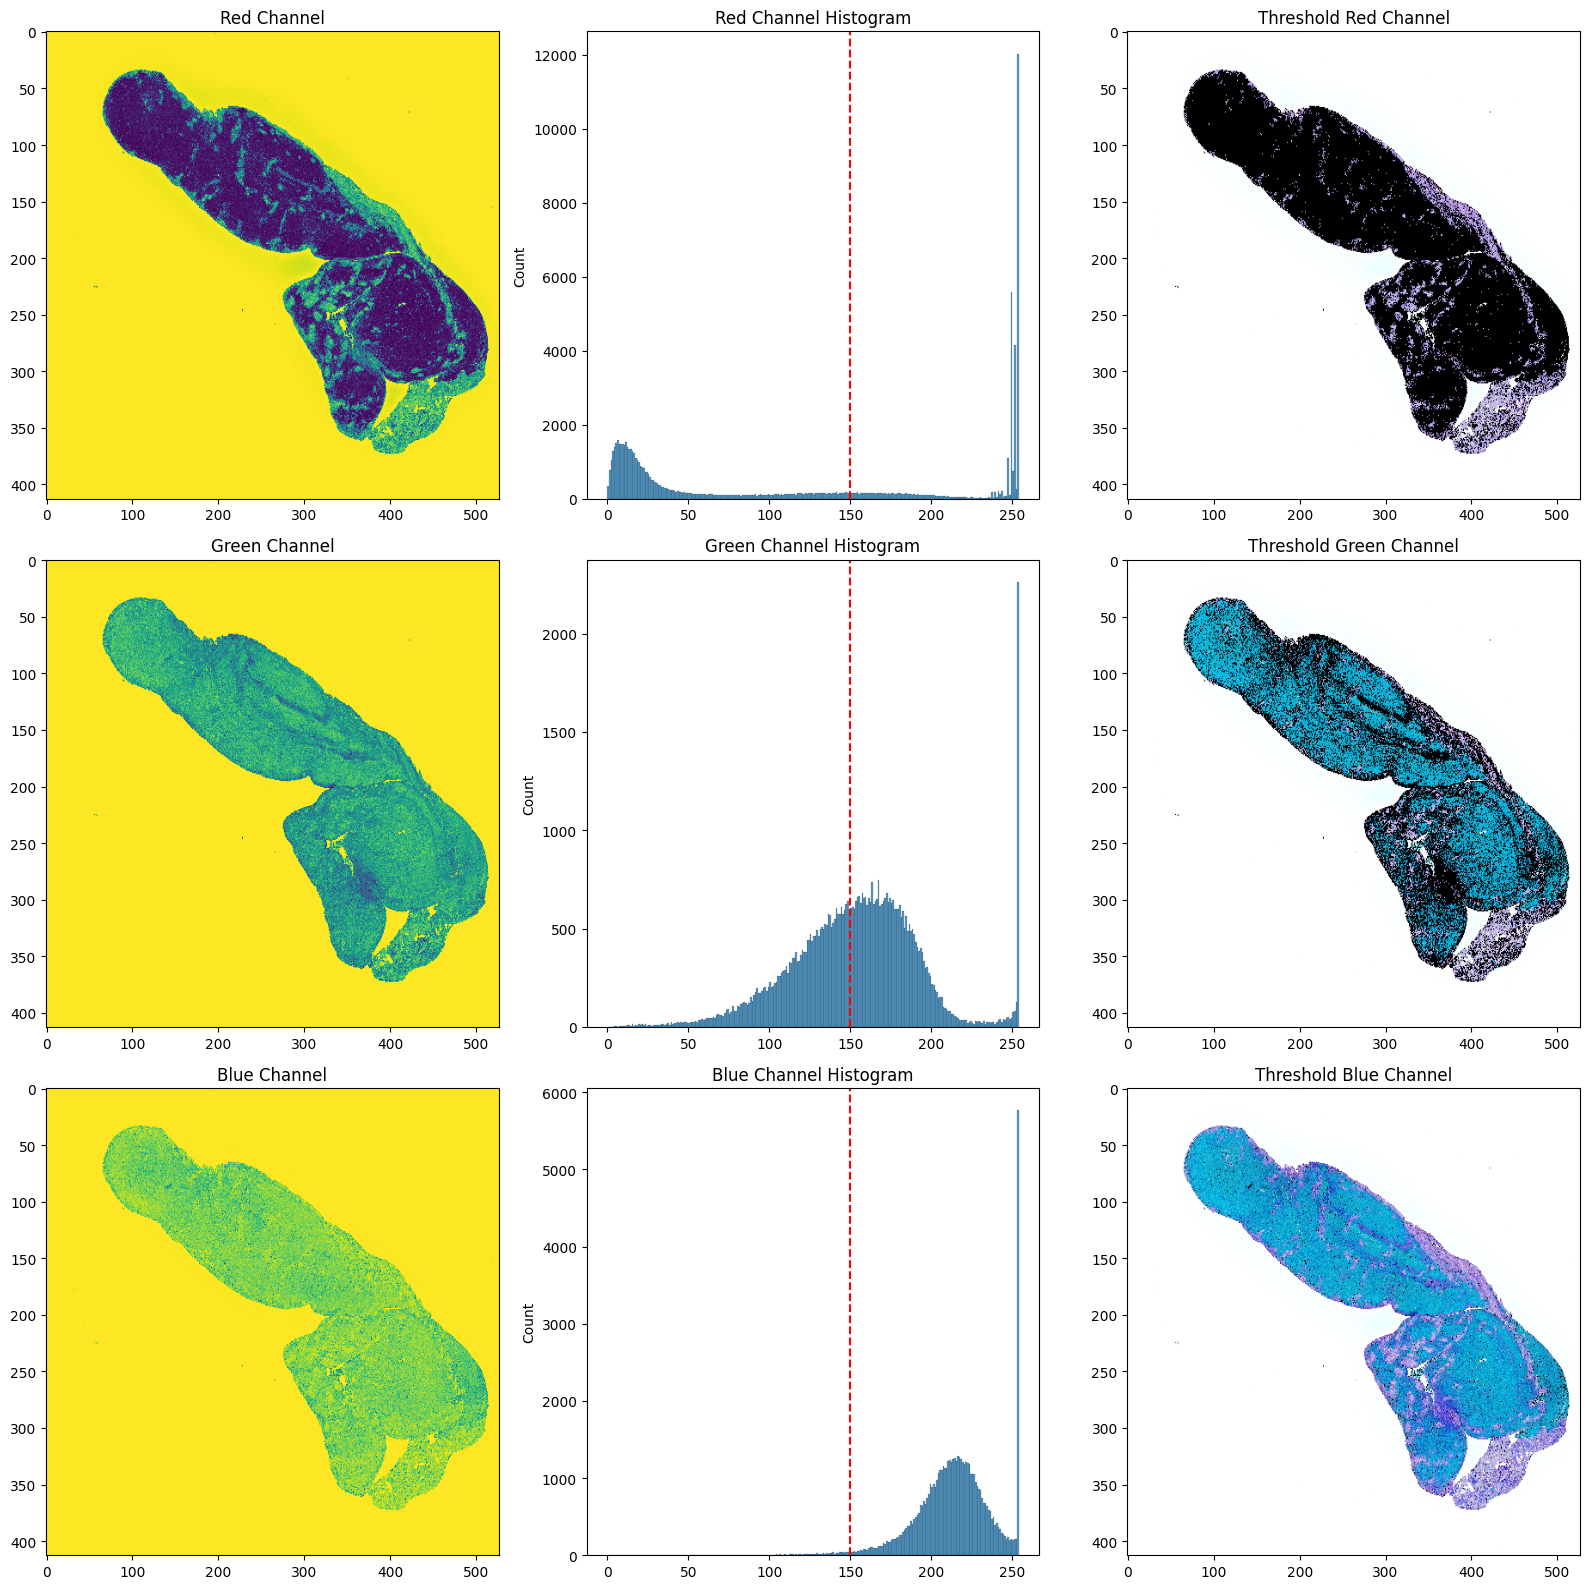

In [23]:
color_channel_analysis(img_resized_CE)

## *Large Artery Atherosclerosis (LAA)*

In [24]:
# Select img with width, height < 16k
img_data.loc[img_data['label']=='LAA'].head(10).style.apply(highlight([24]), axis=1)

Case study : 08d3d8_0

------------------------------

General info: 

Patient ID: 08d3d8
Center ID: 4
Etiology type: LAA

------------------------------

Image info: 

Original shape: 
(15719, 12171, 3)
Resized shape: 
(786, 609, 3)


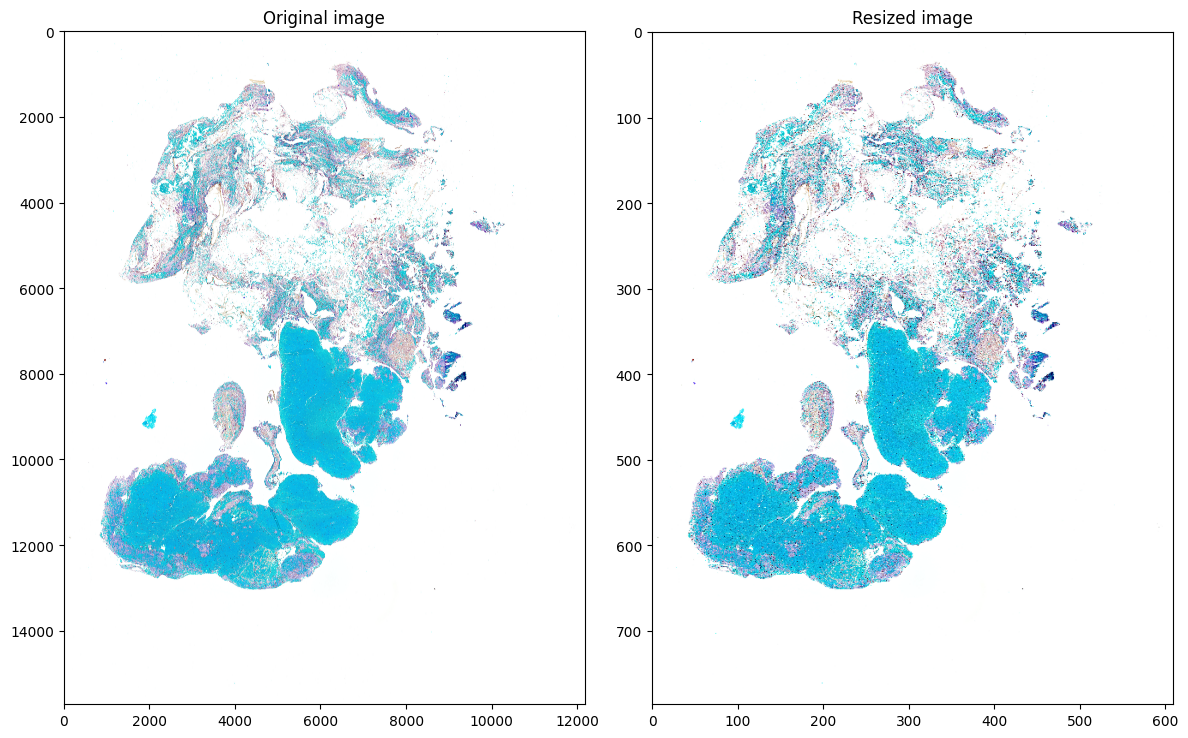

In [25]:
img_LAA, img_resized_LAA = case_study(img_data, '08d3d8_0')

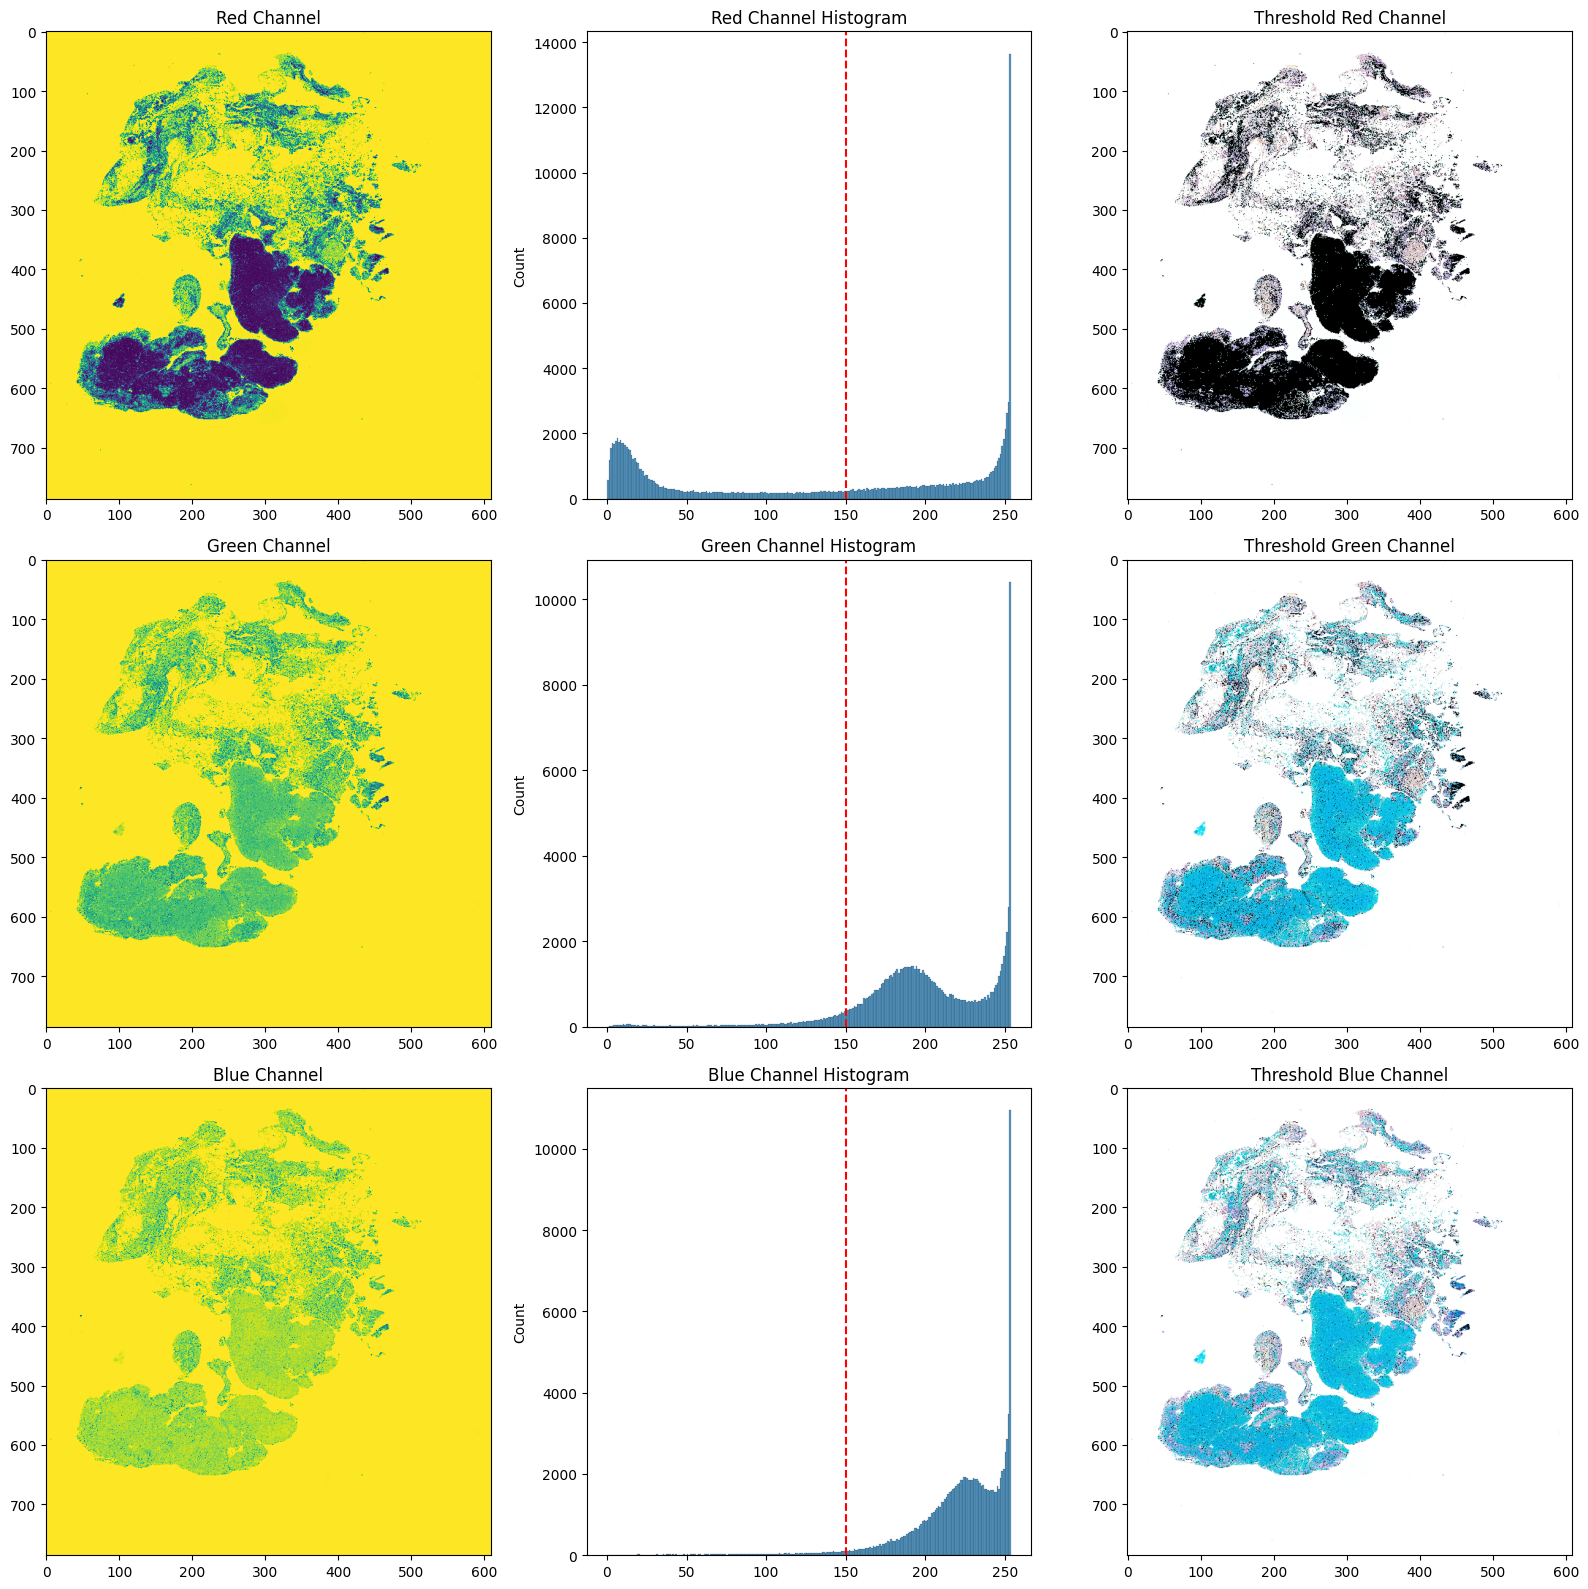

In [26]:
color_channel_analysis(img_resized_LAA)